In [ ]:
#In this approach, I'm going to use SMOTE with Imbalance Data using imblearn module.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/content/drive/My Drive/ML Project Taxi Fair/train.csv')
df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [ ]:
#Just check nan for refresh the memory. It's been 8 days since last submits. Things are getting blur on my memory.
df.isna().sum()/df.shape[0]*100

tripid                       0.000000
additional_fare              1.176060
duration                     1.176060
meter_waiting                1.176060
meter_waiting_fare           1.176060
meter_waiting_till_pickup    1.176060
pickup_time                  0.000000
drop_time                    0.000000
pick_lat                     0.000000
pick_lon                     0.000000
drop_lat                     0.000000
drop_lon                     0.000000
fare                         0.797625
label                        0.000000
dtype: float64

In [ ]:
#1% are related to nan values.I decided to remove the nan rows
df.dropna(subset=['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','pickup_time', 'fare'], inplace=True)
df.drop(columns=['tripid'], inplace=True)

In [ ]:
#Ok, NaN are removed now. Let's re assure it.
df.isna().sum()/df.shape[0]*100

additional_fare              0.0
duration                     0.0
meter_waiting                0.0
meter_waiting_fare           0.0
meter_waiting_till_pickup    0.0
pickup_time                  0.0
drop_time                    0.0
pick_lat                     0.0
pick_lon                     0.0
drop_lat                     0.0
drop_lon                     0.0
fare                         0.0
label                        0.0
dtype: float64

In [ ]:
#Encode the label column

def encode(x):
  if x=='correct':
    return 1
  else:
    return 0

df['label'] = df['label'].apply(encode)

In [ ]:
#Oh I forgot to mentioned , I'm gonna delete the pickup_time and drop_time from dataframe
df.drop(columns=['pickup_time','drop_time'], inplace=True)

In [ ]:
#The datapoint with values 12795.03 is a outlier
#Find the index and remove it
df[df.additional_fare > 2000]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
14043,12795.03,40.0,210164.0,12252.5612,182.0,7.15515,79.8718,7.15537,79.8799,25097.59,0


In [ ]:
#Delete the index 14043
df.drop([14043], inplace=True)

In [ ]:
#The datapoint with values 48.132000 is a outlier
#Find the index and remove it
df[df.drop_lat > 40]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
920,10.5,313.0,50.0,2.915,98.0,7.46897,80.6227,48.132,45.3077,63.41,1


In [ ]:
#Delete the index 920
df.drop([920], inplace=True)

In [ ]:
#Convert np.log and minmax transformation
columns = [col for col in list(df.columns) if col!='label']

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()

for col in columns:

  #There weresome values which tranform inf or -inf in log scale, So add 1 for ech column
  df[col] = df[col]+1
  log_tranform = np.log(df[col].values.reshape(-1, 1))
  scaler1.fit(log_tranform)
  df[col] = scaler1.transform(log_tranform)

In [ ]:
df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,-0.118493,-0.113264,-0.323926,-0.816484,0.168468,-0.471004,-0.406459,-0.280295,-0.497783,0.273197,1
1,-0.118493,-0.164693,-0.419023,-0.816484,0.630810,-0.360140,-0.410181,-0.231168,-0.439910,-0.127441,1
2,-0.118493,0.144185,-0.129474,-0.816484,0.138577,-0.253714,-0.547949,-0.123250,-0.347747,0.414043,1
3,-0.118493,-0.436378,0.540849,0.898053,0.206245,-0.172043,-0.446997,-0.166502,-0.420070,-1.249235,1
5,-0.118493,1.254842,0.321541,-0.816484,0.518283,0.797087,-0.416386,-0.208016,-0.553186,2.037416,1


In [ ]:
X = df.drop(columns=['label']).values
y = df['label']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (16966, 10)
Shape of y: (16966,)


In [ ]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number rides X_train dataset: ", X_train.shape)
print("Number rides y_train dataset: ", y_train.shape)
print("Number rides X_test dataset: ", X_test.shape)
print("Number rides y_test dataset: ", y_test.shape)

Number rides X_train dataset:  (11876, 10)
Number rides y_train dataset:  (11876,)
Number rides X_test dataset:  (5090, 10)
Number rides y_test dataset:  (5090,)


In [ ]:
#So far so good. Nan are eleminated
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 10818
Before OverSampling, counts of label '0': 1058 

After OverSampling, the shape of train_X: (21636, 10)
After OverSampling, the shape of train_y: (21636,) 

After OverSampling, counts of label '1': 10818
After OverSampling, counts of label '0': 10818


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

LR: 0.956503 (0.001109)
LDA: 0.958166 (0.001536)
KNN: 0.965656 (0.001667)
CART: 0.953672 (0.003882)
NB: 0.937273 (0.004521)


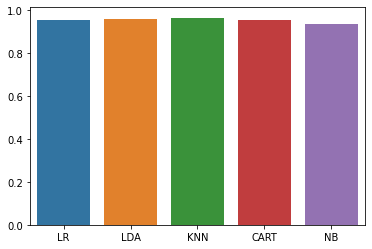

In [ ]:

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(max_depth=30)))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma=0.05, kernel='linear')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
sns.barplot(x=np.array(['LR','LDA','KNN','CART','NB']),y=[r.mean() for r in results])

In [ ]:
#ANN

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
# load the dataset
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)
# make class predictions with the model


Epoch 1/150
11876/11876 [==============================] - 2s 144us/step - loss: 0.3717 - acc: 0.8788 - f1_m: 0.9234 - precision_m: 0.9042 - recall_m: 0.9618
Epoch 2/150
11876/11876 [==============================] - 2s 135us/step - loss: 0.2531 - acc: 0.9171 - f1_m: 0.9540 - precision_m: 0.9192 - recall_m: 0.9963
Epoch 3/150
11876/11876 [==============================] - 2s 130us/step - loss: 0.2121 - acc: 0.9267 - f1_m: 0.9588 - precision_m: 0.9327 - recall_m: 0.9910
Epoch 4/150
11876/11876 [==============================] - 1s 122us/step - loss: 0.1933 - acc: 0.9328 - f1_m: 0.9620 - precision_m: 0.9400 - recall_m: 0.9891
Epoch 5/150
11876/11876 [==============================] - 1s 118us/step - loss: 0.1823 - acc: 0.9367 - f1_m: 0.9642 - precision_m: 0.9444 - recall_m: 0.9888
Epoch 6/150
11876/11876 [==============================] - 1s 121us/step - loss: 0.1748 - acc: 0.9397 - f1_m: 0.9657 - precision_m: 0.9475 - recall_m: 0.9883
Epoch 7/150
11876/11876 [===========================

In [ ]:
#Acc of 0.9500 training

In [ ]:
#Create sample submission file using ANN train f1 : 0.9736

#Testing frame
test_frame = pd.read_csv("/content/drive/My Drive/ML Project Taxi Fair/test.csv")
trip_ids = test_frame['tripid']

test_frame.drop(columns=['tripid','pickup_time','drop_time'], inplace=True)

#From now .I try to transform every column to np.log => MinMax Scaler

new_dt_sample = {}

for column in test_frame.columns:
  values = np.log((test_frame[column]+1).values).reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler1.fit(np.log((test_frame[column]+1).values).reshape(-1, 1))
  values = scaler1.transform(np.log((test_frame[column]+1).values).reshape(-1, 1))
  values = [x[0] for x in values]
  new_dt_sample[column] = values

new_df_sample = pd.DataFrame(new_dt_sample)

X_test = new_df_sample.values
predicted = model.predict_classes(X_test)

data_dict = { 'tripid':trip_ids, 'prediction':[x[0] for x in predicted]}
pd_test_result = pd.DataFrame(data=data_dict)

pd_test_result.to_csv('/content/drive/My Drive/ML Project Taxi Fair/sample_submission.csv', index=False)

In [ ]:
#Accuracy of 0.97345 submission